### Import Libraries

In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.cm import ScalarMappable

### Loading Data

In [2]:
# Get data from CSV
dataUsers = pd.read_csv("data/input/steam-200k.csv", header=None, names=['user', 'game', 'purchase_play', 'hrs', 'tmp'])
dataUsers.drop('tmp', inplace=True, axis=1)

In [3]:
dataUsers.head(4)

,user,game,purchase_play,hrs
0,151603712,The Elder Scrolls V Skyrim,purchase,1.0
1,151603712,The Elder Scrolls V Skyrim,play,273.0
2,151603712,Fallout 4,purchase,1.0
3,151603712,Fallout 4,play,87.0


In [4]:
len(dataUsers['user'].unique())

12393

In [5]:
len(dataUsers['game'].unique())

5155

### Data Pre-processing

#### Reformating purchase and play columns

In [6]:
dataUsers_clean = dataUsers
dataUsers_clean['purchase'] = dataUsers_clean['purchase_play'] == 'purchase'
dataUsers_clean['purchase'] = dataUsers_clean['purchase'].astype(int)
dataUsers_clean['play'] = dataUsers_clean['purchase_play'] == 'play'
dataUsers_clean['play'] = dataUsers_clean['play'].astype(int)
dataUsers_clean['hrs'] = dataUsers_clean['hrs'] - dataUsers_clean['purchase']
dataUsers_clean = dataUsers_clean.groupby(by=['user', 'game']).agg({'hrs': 'sum', 'purchase': 'sum', 'play': 'sum'}).reset_index()

In [7]:
dataUsers_clean.head(4)

,user,game,hrs,purchase,play
0,5250,Alien Swarm,4.9,1,1
1,5250,Cities Skylines,144.0,1,1
2,5250,Counter-Strike,0.0,1,0
3,5250,Counter-Strike Source,0.0,1,0


#### Converting number of hours played into rating scale (1-5)

In [8]:
# check total number of rows with hours played equal to 0
dataUsers_clean[dataUsers_clean['hrs'] == 0.0].count()

user        58327
game        58327
hrs         58327
purchase    58327
play        58327
dtype: int64

In [9]:
# convert hours to mins
dataUsers_clean['hrs'] = dataUsers_clean['hrs'] * 60

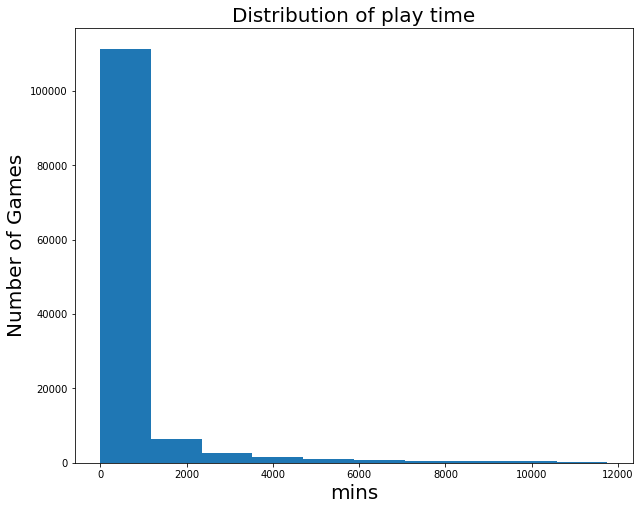

In [10]:
def DistributionPlot(col, r1, r2, bins):    
    import matplotlib.pyplot as plt
    plt.figure(figsize=(10,8))
    plt.hist(x=dataUsers_clean[col], range=[r1, r2], bins=bins)

    # Add title and axis names
    plt.title('Distribution of play time', fontsize=20)
    plt.ylabel('Number of Games', fontsize=20)
    plt.xlabel('mins', fontsize=20)

    plt.show()
    
DistributionPlot('hrs', 0 , 11754, 10)

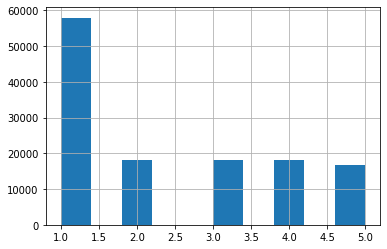

In [44]:
# Distributing the data into bins
def jitter(a_series, noise_reduction=1000000):
    return (np.random.random(len(a_series))*a_series.std()/noise_reduction)-(a_series.std()/(2*noise_reduction))

dataUsers_clean['rating'] = pd.qcut(dataUsers_clean['hrs'] + jitter(dataUsers_clean['hrs']), q=[0, 0.45, 0.59, 0.73, 0.87, 1], labels=[1, 2, 3, 4, 5])
dataUsers_clean['rating'].hist()

In [45]:
# set rating = 1 for all records with 0 hrs
dataUsers_clean.loc[dataUsers_clean.hrs == 0.0, 'rating'] = 1
dataUsers_clean['rating'].value_counts()

1    58327
3    18033
4    18032
2    17667
5    16745
Name: rating, dtype: int64

In [46]:
dataUsers_clean.head(5)

,user,game,hrs,purchase,play,rating
0,5250,Alien Swarm,294.0,1,1,4
1,5250,Cities Skylines,8640.0,1,1,5
2,5250,Counter-Strike,0.0,1,0,1
3,5250,Counter-Strike Source,0.0,1,0,1
4,5250,Day of Defeat,0.0,1,0,1


In [47]:
# Store clean data
dataUsers_clean.to_csv('data/cleaned/purchase_play_rating.csv',
                       index=False)

### Exploratory Data Analysis

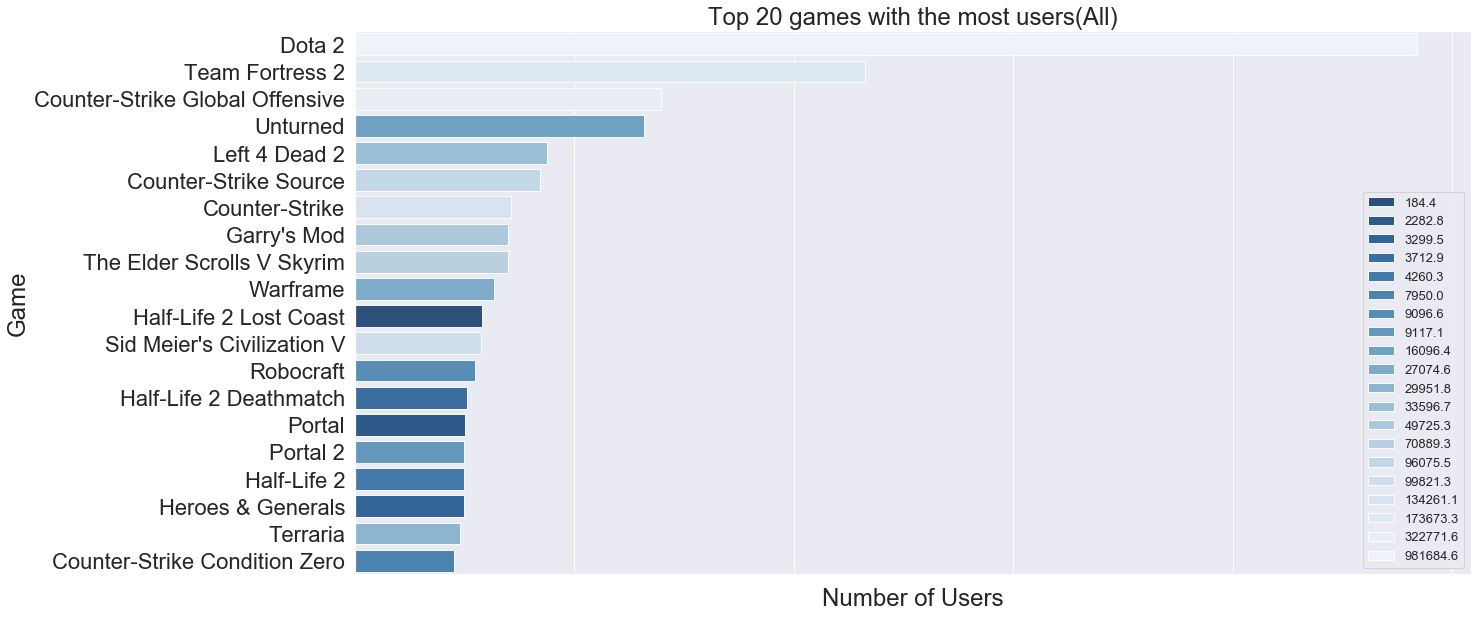

In [49]:
game_total_hrs = dataUsers_clean.groupby(by='game')['hrs'].sum()
most_played_games = game_total_hrs.sort_values(ascending=False)[:20]


# game with the highest number of users
game_freq = dataUsers.groupby(by='game').agg({'user': 'count', 'hrs': 'sum'}).reset_index()
top20 = game_freq.sort_values(by='user',ascending=False)[:20].reset_index()
top20['hrs']=top20['hrs'].round(1)

# show histogram
plt.figure(figsize=(20, 10))
sns.set(font_scale = 2)
ax = sns.barplot(x='user', y='game', hue='hrs',alpha=0.9,data=top20, palette='Blues_r',dodge=False)
ax.set(xlabel='Number of Users', ylabel='Game', title='Top 20 games with the most users(All)')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.legend(fontsize=13)
plt.show()

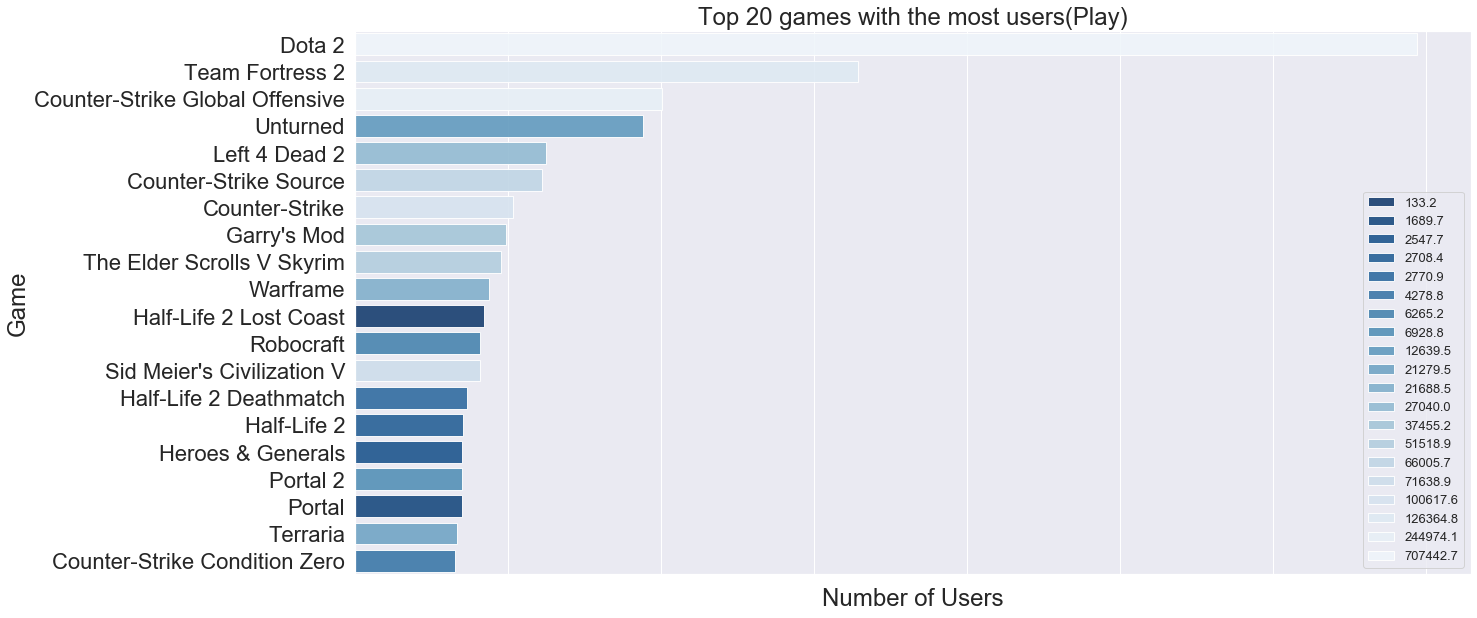

In [50]:
#consider the situation that only included play
index=dataUsers_clean[dataUsers_clean['play']==0].index
dataUsers.drop(index,inplace=True)
game_total_hrs = dataUsers.groupby(by='game')['hrs'].sum()
most_played_games = game_total_hrs.sort_values(ascending=False)[:20]

# game with the highest number of users
game_freq = dataUsers.groupby(by='game').agg({'user': 'count', 'hrs': 'sum'}).reset_index()
top20 = game_freq.sort_values(by='user',ascending=False)[:20].reset_index()
top20['hrs']=top20['hrs'].round(1)

plt.figure(figsize=(20, 10))
sns.set(font_scale = 2)
ax = sns.barplot(x='user', y='game', hue='hrs',alpha=0.9,data=top20, palette='Blues_r',dodge=False)
ax.set(xlabel='Number of Users', ylabel='Game', title='Top 20 games with the most users(Play)')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.legend(fontsize=13)
plt.show()